In [1]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

from einops import rearrange, reduce
from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from bliss.cached_dataset import CachedSimulatedDataModule
from case_studies.dc2_mdt.utils.rml_encoder import M2MDTFullRMLEncoder

In [2]:
model_name = "exp_07-07-1"
model_check_point_name = "encoder_169.ckpt"
model_path = "../../../bliss_output/m2_mdt_only_nsources_rml_exp_07-07-1_encoder_169.ckpt"
cached_data_path =  Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
with initialize(config_path="./m2_mdt_config", version_base=None):
    cfg = compose("m2_mdt_only_nsources_rml_train_config")

In [3]:
seed = cfg.train.seed
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [4]:
batch_size = 800
m2: CachedSimulatedDataModule = instantiate(cfg.cached_simulator)
m2.batch_size = batch_size
m2.setup(stage="validate")
m2_val_dataloader = m2.val_dataloader()

In [5]:
my_encoder: M2MDTFullRMLEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
my_encoder.load_state_dict(pretrained_weights)
my_encoder.eval();

ddim_sampling_steps = 3
ddim_eta = 0.0
my_encoder.reconfig_sampling(new_sampling_time_steps=ddim_sampling_steps, new_ddim_eta=ddim_eta)

In [6]:
cached_file_name = f"m2_mdt_only_nsources_rml_posterior_" \
                        f"{model_name}_{model_check_point_name}_" \
                        f"ddim_steps_{ddim_sampling_steps}_" \
                        f"eta_{ddim_eta:.1f}_" \
                        f"seed_{seed}.pt"
save_path = cached_data_path / cached_file_name
if not os.path.isfile(save_path):
    print(f"can't find cached file [{cached_file_name}]; rerun the inference")
    diffusion_result_dict = {
        "pred_n_sources_list": [],
        "pred_x0_list": [],
        "target1_n_sources_list": [],
        "target1_locs_list": [],
        "target1_fluxes_list": [],
        "target2_n_sources_list": [],
        "target2_locs_list": [],
        "target2_fluxes_list": [],
    }

    for one_batch in tqdm.tqdm(m2_val_dataloader):
        one_batch = move_data_to_device(one_batch, device=device)

        target_tile_cat = TileCatalog(one_batch["tile_catalog"])
        target_cat1 = target_tile_cat.get_brightest_sources_per_tile(
            band=0, exclude_num=0
        )
        target_cat2 = target_tile_cat.get_brightest_sources_per_tile(
            band=0, exclude_num=1
        )
        diffusion_result_dict["target1_n_sources_list"].append(target_cat1["n_sources"].cpu())
        diffusion_result_dict["target1_locs_list"].append(target_cat1["locs"].cpu())
        diffusion_result_dict["target1_fluxes_list"].append(target_cat1["fluxes"].cpu())
        diffusion_result_dict["target2_n_sources_list"].append(target_cat2["n_sources"].cpu())
        diffusion_result_dict["target2_locs_list"].append(target_cat2["locs"].cpu())
        diffusion_result_dict["target2_fluxes_list"].append(target_cat2["fluxes"].cpu())

        with torch.inference_mode():
            sample_tile_cat, inter_pred_x0 = my_encoder.sample(one_batch, return_intermediate=True)

        diffusion_result_dict["pred_n_sources_list"].append(sample_tile_cat["n_sources"].cpu())
        diffusion_result_dict["pred_x0_list"].append(inter_pred_x0)
        # diffusion_result_dict["pred_locs_list"].append(sample_tile_cat["locs"].cpu())  # (b, h, w, 2, 2)
        # diffusion_result_dict["pred_fluxes_list"].append(sample_tile_cat["fluxes"].cpu())  # (b, h, w, 2, 6)

    torch.save(diffusion_result_dict, save_path)
else:
    print(f"find the cached file [{cached_file_name}]; run nothing")
    with open(cached_data_path / cached_file_name, "rb") as f:
        diffusion_result_dict = torch.load(f, map_location="cpu")

find the cached file [m2_mdt_only_nsources_rml_posterior_exp_07-07-1_encoder_169.ckpt_ddim_steps_3_eta_0.0_seed_7272.pt]; run nothing


In [7]:
with open(cached_data_path / "m2_bliss_posterior_exp_07-03-1_encoder_43.ckpt_whole_val_set_seed_7272.pt", "rb") as f:
    bliss_result_dict = torch.load(f, map_location="cpu")

In [8]:
for k, v in bliss_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 2, 1])
target1_n_sources_list[0]: torch.Size([800, 20, 20])
target1_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])
target2_n_sources_list[0]: torch.Size([800, 20, 20])
target2_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])


## N Sources CM

In [9]:
diffusion_true_ns = []
diffusion_pred_ns = []
for true1_ns, true2_ns, pred_ns in zip(diffusion_result_dict["target1_n_sources_list"],
                                        diffusion_result_dict["target2_n_sources_list"],
                                        diffusion_result_dict["pred_n_sources_list"],
                                        strict=True):
    diffusion_pred_ns.append(pred_ns)
    diffusion_true_ns.append(true1_ns + true2_ns)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)

In [10]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([24576, 20, 20]), torch.Size([24576, 20, 20]))

In [11]:
bliss_true_ns = []
bliss_pred_ns = []
for true1_ns, true2_ns, pred_ns in zip(bliss_result_dict["target1_n_sources_list"],
                                        bliss_result_dict["target2_n_sources_list"],
                                        bliss_result_dict["pred_n_sources_list"],
                                        strict=True):
    bliss_pred_ns.append(pred_ns)
    bliss_true_ns.append(true1_ns + true2_ns)
bliss_true_ns = torch.cat(bliss_true_ns, dim=0)
bliss_pred_ns = torch.cat(bliss_pred_ns, dim=0)

In [12]:
bliss_true_ns.shape, bliss_pred_ns.shape

(torch.Size([24576, 20, 20]), torch.Size([24576, 20, 20]))

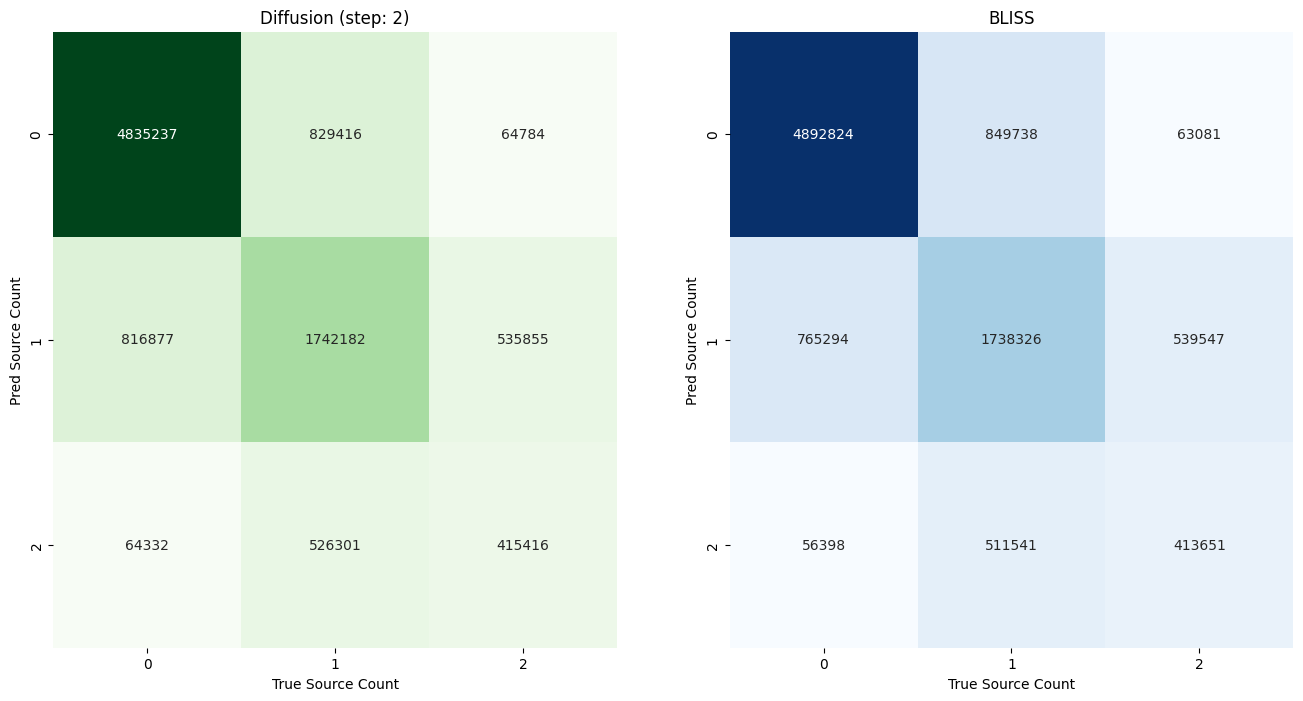

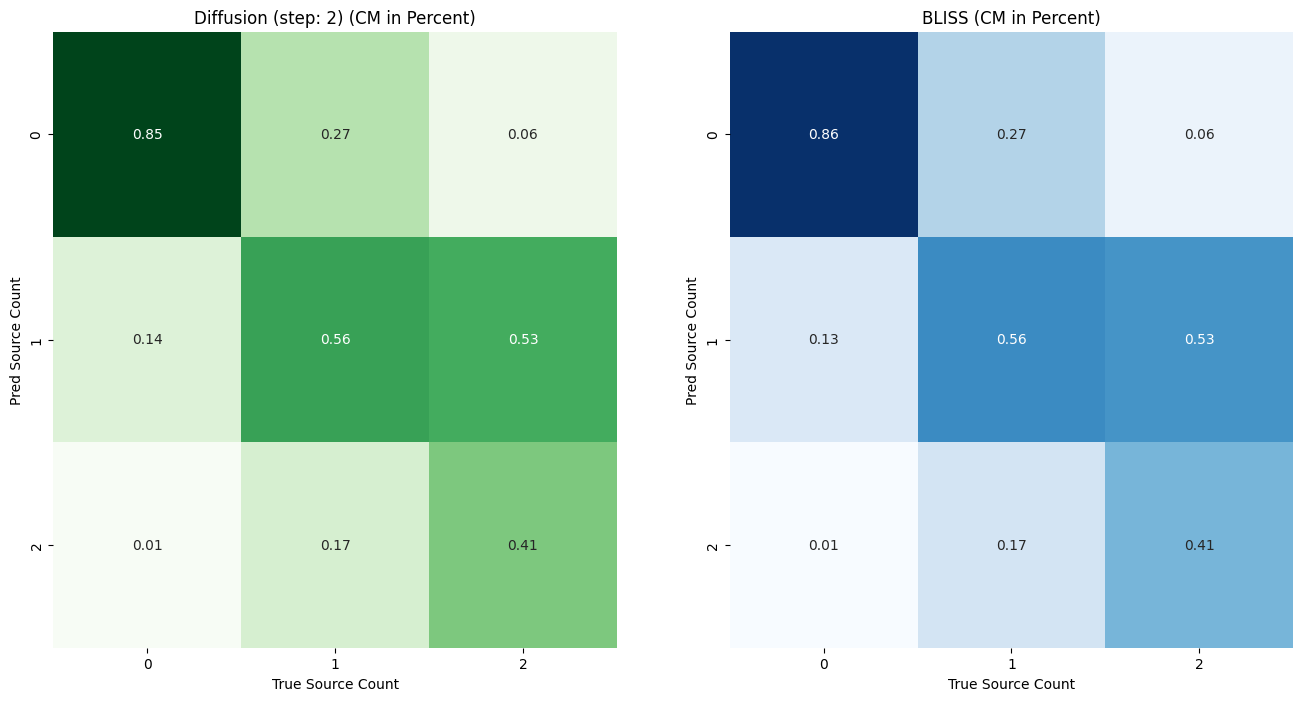

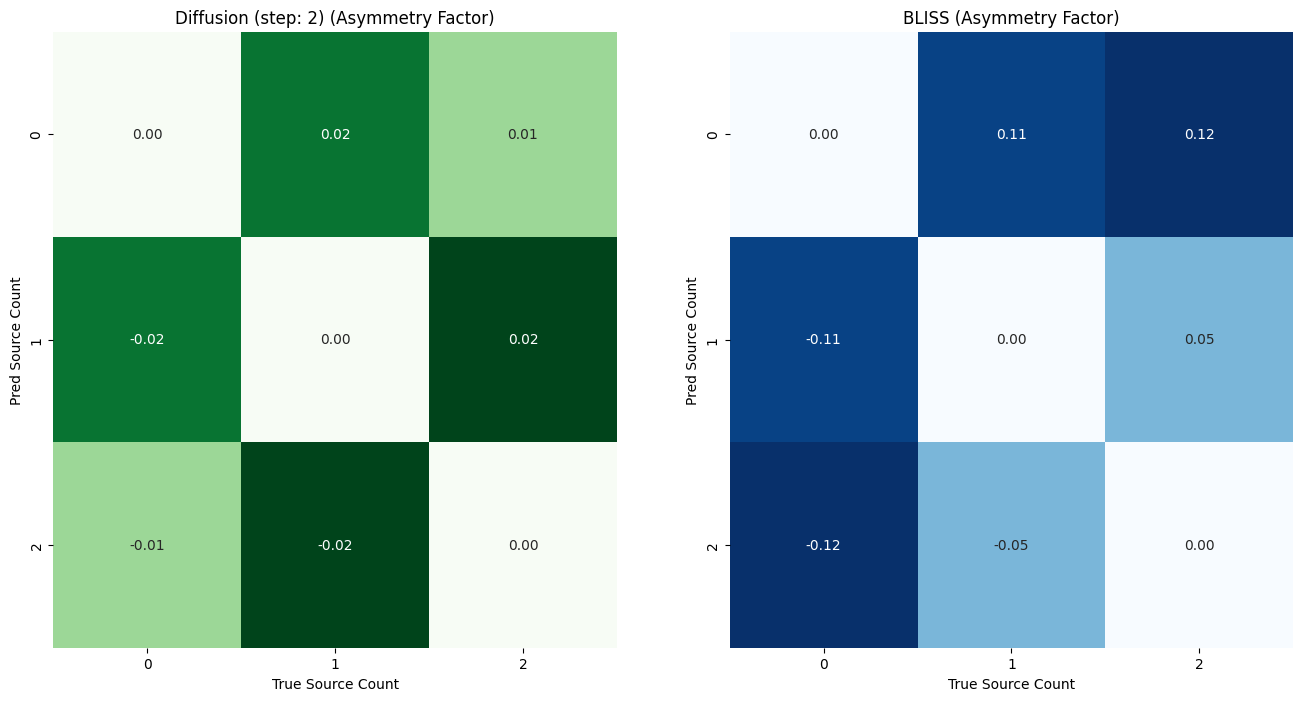

In [13]:
d_cm = torch.zeros(3, 3, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((diffusion_pred_ns == ri) & (diffusion_true_ns == ci)).sum()

b_cm = torch.zeros(3, 3, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((bliss_pred_ns == ri) & (bliss_true_ns == ci)).sum()

bin_labels = [i for i in range(3)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title(f"Diffusion (step: {ddim_sampling_steps - 1})")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title(f"Diffusion (step: {ddim_sampling_steps - 1}) (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
            annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title(f"Diffusion (step: {ddim_sampling_steps - 1}) (Asymmetry Factor)")
sns.heatmap(((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1)).abs(),
            annot=(b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()

In [14]:
len(diffusion_result_dict["pred_x0_list"][0])

2

In [15]:
diffusion_result_dict["pred_x0_list"][0][0].shape

torch.Size([800, 2, 20, 20])

In [16]:
diffusion_result_dict["pred_x0_list"][0][0][2].permute([1, 2, 0])[:5, :5]

tensor([[[ 0.9220, -0.9982],
         [ 1.0000,  1.0000],
         [ 1.0000, -0.9744],
         [-1.0000, -1.0000],
         [ 0.9944,  0.9707]],

        [[ 0.9810, -1.0000],
         [ 1.0000, -0.7789],
         [-0.9959, -1.0000],
         [ 1.0000, -0.8282],
         [-0.9637, -1.0000]],

        [[ 1.0000, -0.9895],
         [-1.0000, -1.0000],
         [-0.9507, -0.9772],
         [ 1.0000,  0.9275],
         [-1.0000, -1.0000]],

        [[ 0.9557, -0.9840],
         [-0.9340, -1.0000],
         [-0.9070, -0.8890],
         [ 0.9980,  1.0000],
         [-0.9766, -1.0000]],

        [[-1.0000, -1.0000],
         [-1.0000, -1.0000],
         [-1.0000, -0.9965],
         [-1.0000, -1.0000],
         [ 0.9153, -1.0000]]])

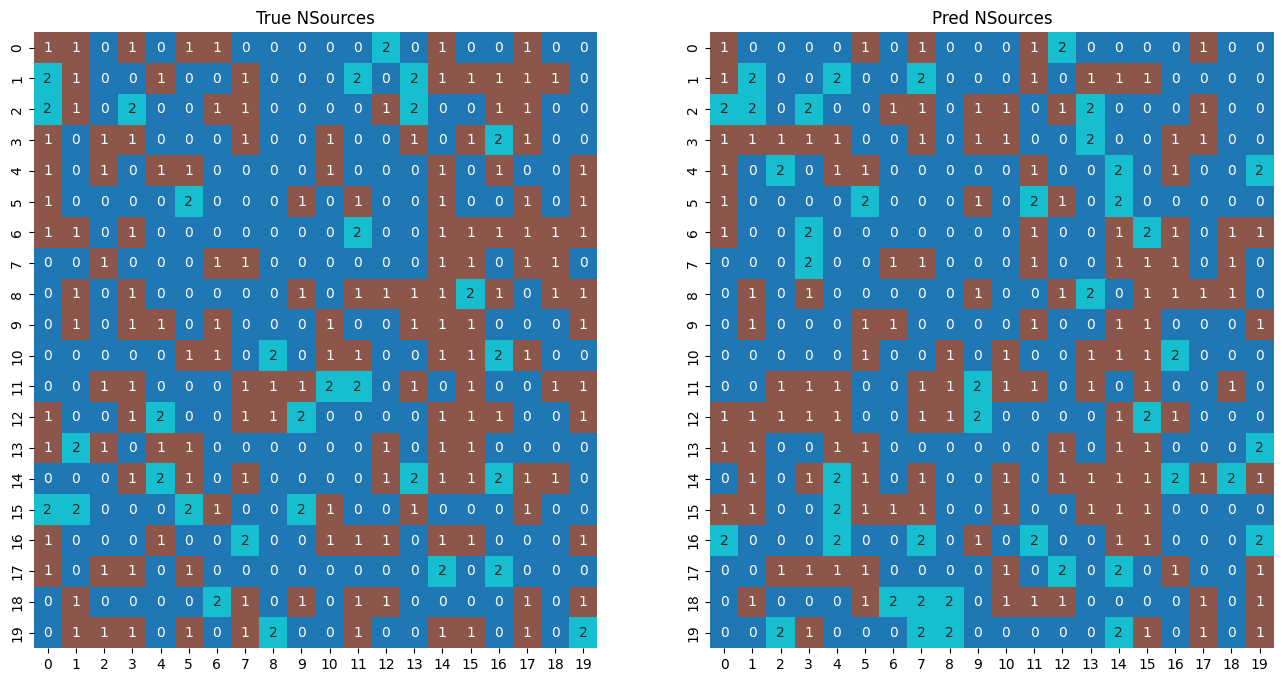

In [17]:
test_i = 10
test_sub_i = 255
true1_ns = diffusion_result_dict["target1_n_sources_list"][test_i][test_sub_i]
true2_ns = diffusion_result_dict["target2_n_sources_list"][test_i][test_sub_i]
true_ns = true1_ns + true2_ns
pred_ns = diffusion_result_dict["pred_n_sources_list"][test_i][test_sub_i]
assert true1_ns.shape == pred_ns.shape

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
tick_labels = list(range(20))
sns.heatmap(true_ns,
            annot=True,
            fmt="d", cmap="tab10", cbar=False,
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            ax=axes[0])
axes[0].set_title("True NSources")

sns.heatmap(pred_ns,
            annot=True,
            fmt="d", cmap="tab10", cbar=False,
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            ax=axes[1])
axes[1].set_title("Pred NSources")
fig.show()

In [18]:
def plot_trace_for_tilles(pred_traces: list[torch.Tensor], tile_indexes: list[tuple[int]]):
    assert pred_traces[0].shape == (20, 20, 2)

    num_s = len(tile_indexes) * 2
    ncols = 4
    nrows = math.ceil(num_s / ncols)
    fig, axes = plt.subplots(nrows, ncols, 
                             figsize=(4 * ncols, 4 * nrows), 
                             constrained_layout=True)
    axes = axes.flatten()
    for i, ti in enumerate(tile_indexes):
        tile_iy = ti[0]
        tile_ix = ti[1]
        trace1 = [p[tile_iy, tile_ix, 0].item() for p in pred_traces]
        trace2 = [p[tile_iy, tile_ix, 1].item() for p in pred_traces]
        x = range(len(trace1))
        axes[i * 2].plot(x, trace1)
        axes[i * 2].set_xlabel("DDIM Steps")
        axes[i * 2].set_title(f"Tile ({tile_iy}, {tile_ix}) s1")
        axes[i * 2 + 1].plot(x, trace2)
        axes[i * 2 + 1].set_xlabel("DDIM Steps")
        axes[i * 2 + 1].set_title(f"Tile ({tile_iy}, {tile_ix}) s2")
    fig.show()

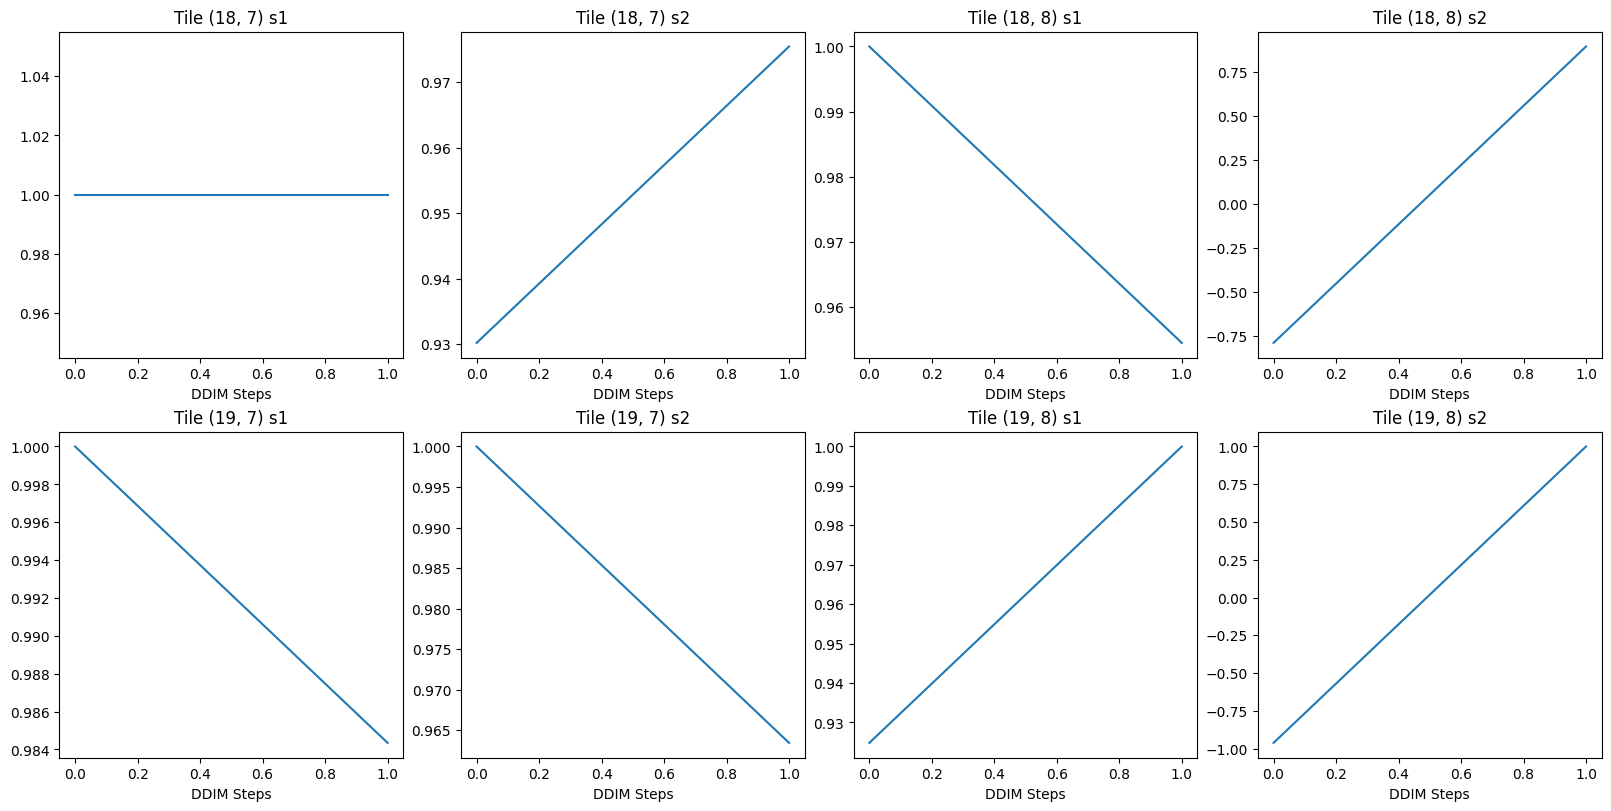

In [21]:
plot_trace_for_tilles([p[test_sub_i].permute([1, 2, 0]) for p in diffusion_result_dict["pred_x0_list"][test_i]],
                      tile_indexes=[(18, 7), (18, 8), (19, 7), (19, 8)])

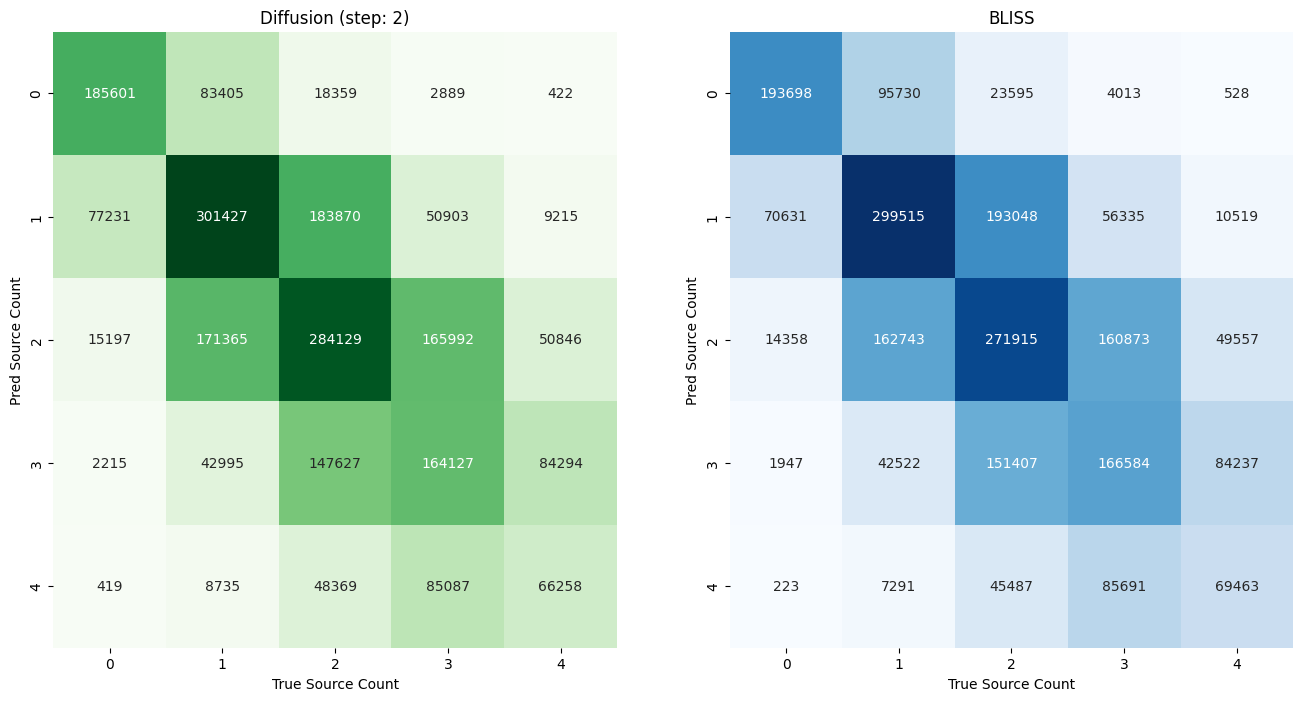

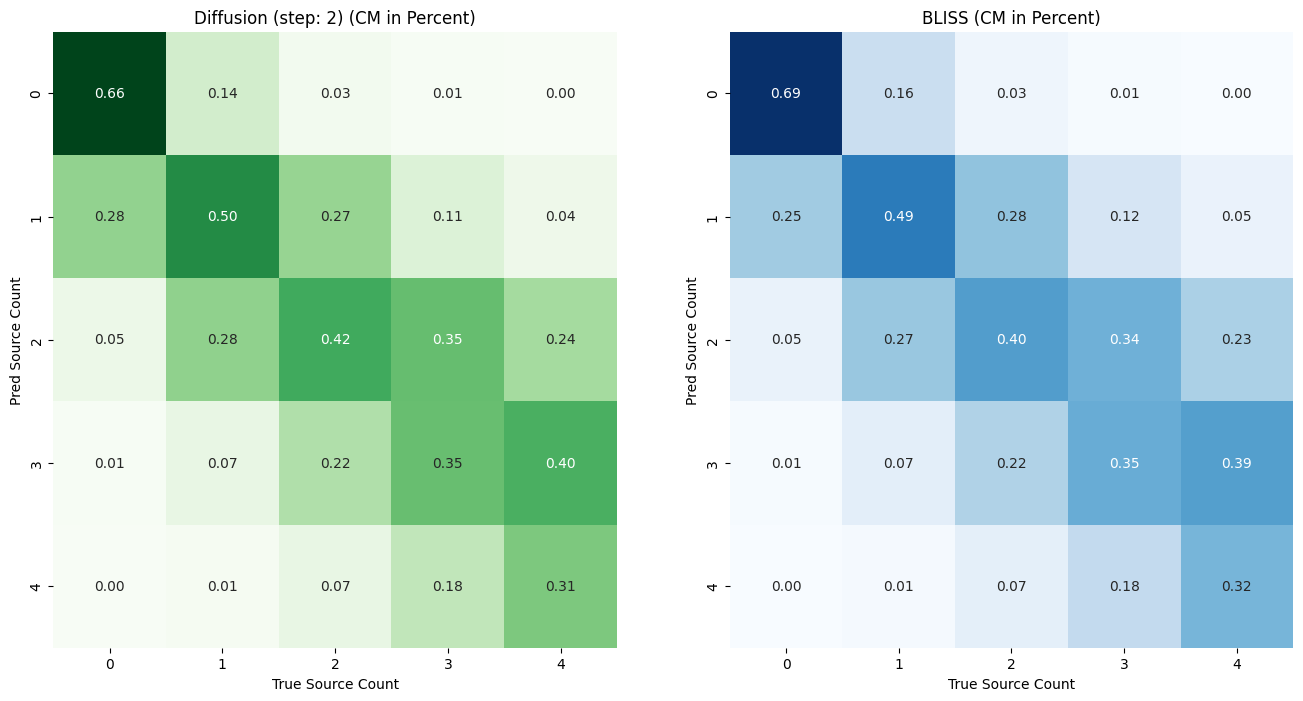

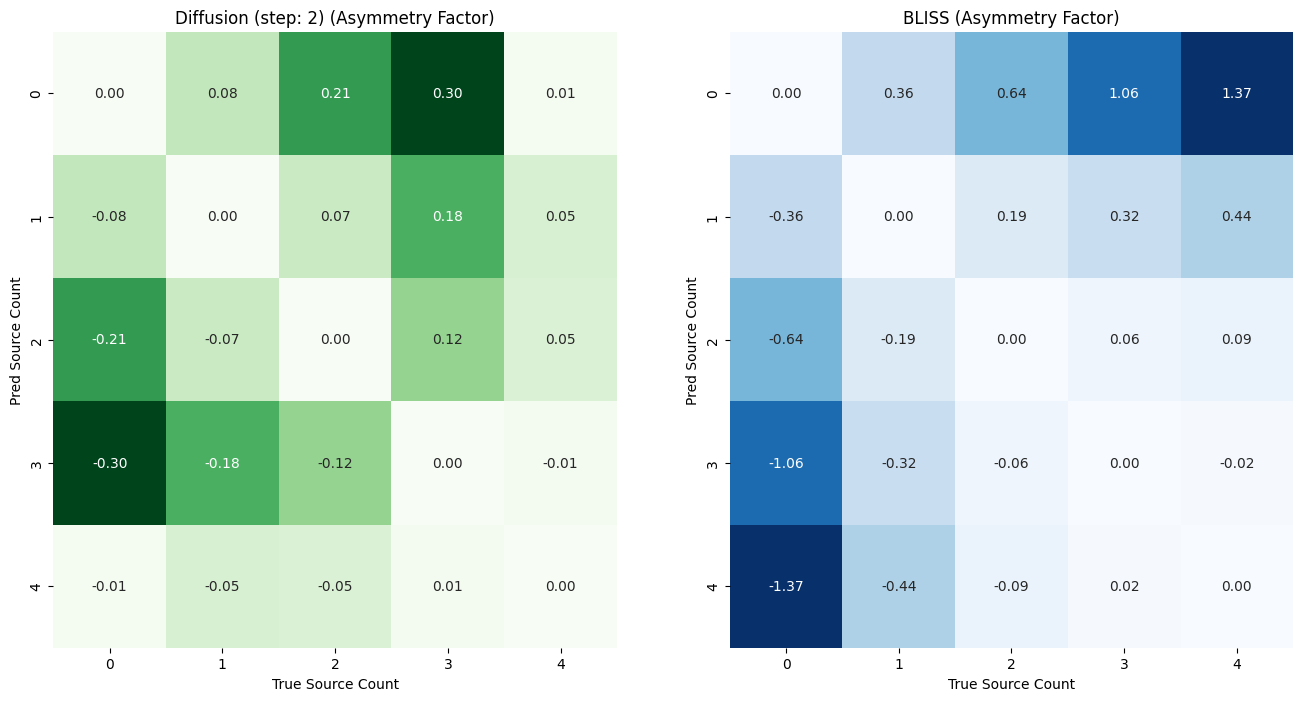

In [20]:
cum_d_pred_ns = reduce(diffusion_pred_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
cum_d_true_ns = reduce(diffusion_true_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
cum_b_pred_ns = reduce(bliss_pred_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
cum_b_true_ns = reduce(bliss_true_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
d_cm = torch.zeros(5, 5, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((cum_d_pred_ns == ri) & (cum_d_true_ns == ci)).sum()

b_cm = torch.zeros(5, 5, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((cum_b_pred_ns == ri) & (cum_b_true_ns == ci)).sum()

bin_labels = [i for i in range(5)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title(f"Diffusion (step: {ddim_sampling_steps - 1})")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title(f"Diffusion (step: {ddim_sampling_steps - 1}) (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
            annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title(f"Diffusion (step: {ddim_sampling_steps - 1}) (Asymmetry Factor)")
sns.heatmap(((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1)).abs(),
            annot=(b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()